
# IEEE VIS Papers 1990–2024 — Comprehensive Exploratory Data Analysis

This notebook performs a **deep exploratory data analysis (EDA)** of the IEEE VIS papers dataset (1990–2024).  
It covers:

1. Dataset overview and basic structure  
2. Column-by-column profiling  
3. Temporal analysis (trends over years, conferences, and paper types)  
4. Author analysis (unique authors, distribution over time, top authors, co-authorship)  
5. Field / topic analysis (keywords, domains, basic topic modeling)  
6. Network analysis (author–author, author–field, institution/city–field)  
7. Visualizations (time series, distributions, and some network statistics)


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For text processing and topic modeling
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# For network analysis
import networkx as nx

# Display options
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Plotting defaults
plt.rcParams["figure.figsize"] = (8, 5)



## 1. Load the dataset


In [2]:

# Load the dataset (already available in the environment)
file_path = "dataset.csv"
df = pd.read_csv(file_path)

df.shape, df.head()


((3877, 20),
   Conference  Year                                              Title                        DOI  \
 0    InfoVis  2011                           D³ Data-Driven Documents      10.1109/tvcg.2011.185   
 1    InfoVis  2014          UpSet: Visualization of Intersecting Sets  10.1109/tvcg.2014.2346248   
 2    InfoVis  2010  Narrative Visualization: Telling Stories with ...      10.1109/tvcg.2010.179   
 3    InfoVis  2006  Hierarchical Edge Bundles: Visualization of Ad...      10.1109/tvcg.2006.147   
 4    InfoVis  2007  Toward a Deeper Understanding of the Role of I...    10.1109/tvcg.2007.70515   
 
                                           Link  FirstPage  LastPage PaperType  \
 0      http://dx.doi.org/10.1109/TVCG.2011.185     2301.0    2309.0         J   
 1  http://dx.doi.org/10.1109/TVCG.2014.2346248     1983.0    1992.0         J   
 2      http://dx.doi.org/10.1109/TVCG.2010.179     1139.0    1148.0         J   
 3      http://dx.doi.org/10.1109/TVCG.2006.147    

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3877 entries, 0 to 3876
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Conference                  3877 non-null   object 
 1   Year                        3877 non-null   int64  
 2   Title                       3877 non-null   object 
 3   DOI                         3877 non-null   object 
 4   Link                        3877 non-null   object 
 5   FirstPage                   3826 non-null   float64
 6   LastPage                    3611 non-null   float64
 7   PaperType                   3877 non-null   object 
 8   Abstract                    3807 non-null   object 
 9   AuthorNames-Deduped         3875 non-null   object 
 10  AuthorNames                 3876 non-null   object 
 11  AuthorAffiliation           3871 non-null   object 
 12  InternalReferences          3248 non-null   object 
 13  AuthorKeywords              2898 

In [39]:
numeric_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(include='object').columns

print("Numeric Columns:", list(numeric_cols))
print("Categorical Columns:", list(categorical_cols))

Numeric Columns: ['Year', 'FirstPage', 'LastPage', 'AminerCitationCount', 'CitationCount_CrossRef', 'PubsCited_CrossRef', 'Downloads_Xplore', 'NumAuthors']
Categorical Columns: ['Conference', 'Title', 'DOI', 'Link', 'PaperType', 'Abstract', 'AuthorNames-Deduped', 'AuthorNames', 'AuthorAffiliation', 'InternalReferences', 'AuthorKeywords', 'Award', 'GraphicsReplicabilityStamp', 'AuthorList', 'KeywordList', 'Domains', 'AffiliationList']


In [41]:
df_fixed = df.copy()

for col in df_fixed.columns:
    if df_fixed[col].apply(lambda x: isinstance(x, list)).any():
        df_fixed[col] = df_fixed[col].astype(str)

unique_counts = df_fixed.nunique().sort_values(ascending=False)
print(unique_counts)

DOI                           3877
Title                         3875
Link                          3875
Abstract                      3806
AuthorNames                   3739
AuthorList                    3720
AuthorNames-Deduped           3719
AuthorAffiliation             3634
AffiliationList               3626
InternalReferences            3180
AuthorKeywords                2882
KeywordList                   2878
Downloads_Xplore              1678
LastPage                      1614
FirstPage                     1588
AminerCitationCount            396
CitationCount_CrossRef         228
PubsCited_CrossRef             119
Domains                         53
Year                            35
NumAuthors                      20
Award                            6
Conference                       4
PaperType                        3
GraphicsReplicabilityStamp       1
dtype: int64



## 2. Basic dataset information

We start by inspecting the overall structure: number of rows and columns, data types, and a quick look at missing values.


In [3]:

print("Dataset shape (rows, columns):", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nNumber of missing values per column:")
print(df.isna().sum())


Dataset shape (rows, columns): (3877, 20)

Column names:
['Conference', 'Year', 'Title', 'DOI', 'Link', 'FirstPage', 'LastPage', 'PaperType', 'Abstract', 'AuthorNames-Deduped', 'AuthorNames', 'AuthorAffiliation', 'InternalReferences', 'AuthorKeywords', 'AminerCitationCount', 'CitationCount_CrossRef', 'PubsCited_CrossRef', 'Downloads_Xplore', 'Award', 'GraphicsReplicabilityStamp']

Data types:
Conference                     object
Year                            int64
Title                          object
DOI                            object
Link                           object
FirstPage                     float64
LastPage                      float64
PaperType                      object
Abstract                       object
AuthorNames-Deduped            object
AuthorNames                    object
AuthorAffiliation              object
InternalReferences             object
AuthorKeywords                 object
AminerCitationCount           float64
CitationCount_CrossRef        floa

In [4]:

# Basic descriptive statistics for numeric columns
df.describe(include=[np.number])


,Year,FirstPage,LastPage,AminerCitationCount,CitationCount_CrossRef,PubsCited_CrossRef,Downloads_Xplore
count,3877.000000,3826.000000,3611.000000,3444.000000,3876.000000,3876.000000,3871.000000
mean,2009.051586,688.094354,730.560233,79.095528,31.191692,34.170021,849.779127
std,9.276090,707.355470,718.796970,143.955137,65.229763,23.273970,1305.992342
min,1990.000000,1.000000,1.000000,0.000000,0.000000,0.000000,15.000000
25%,2002.000000,161.000000,184.000000,14.000000,4.000000,16.000000,170.000000
50%,2009.000000,403.000000,458.000000,40.500000,15.000000,30.000000,520.000000
75%,2017.000000,1040.000000,1102.500000,92.000000,36.250000,48.000000,1060.000000
max,2024.000000,2946.000000,5186.000000,3795.000000,2178.000000,195.000000,31097.000000


In [5]:

# Basic descriptive statistics for non-numeric columns
df.describe(include=["object"])


,Conference,Title,DOI,Link,PaperType,Abstract,AuthorNames-Deduped,AuthorNames,AuthorAffiliation,InternalReferences,AuthorKeywords,Award,GraphicsReplicabilityStamp
count,3877,3877,3877,3877,3877,3807,3875,3876,3871,3248,2898,273,27
unique,4,3875,3877,3875,3,3806,3719,3739,3634,3180,2882,6,1
top,Vis,University of British Columbia & Simon Fraser ...,10.1109/tvcg.2011.185,http://dx.doi.org/10.1109/VISUAL.1998.745291,J,The investigation of the VAST Contest collecti...,Lloyd Treinish,L.A. Treinish,"IBM Thomas J. Watson Research Center, Yorktown...",10.1109/visual.1991.175782;10.1109/visual.1991...,"Information visualization, user interfaces, to...",HM,X
freq,1942,2,1,2,1999,2,6,6,8,5,2,144,27



## 3. Column-by-column profiling

In this section we inspect each column individually:
- value distributions,
- missingness,
- basic semantics,
- and potential issues (e.g., inconsistent formatting).


In [6]:

def summarize_column(series, name, top_n=10):
    print(f"\n{'='*80}")
    print(f"Column: {name}")
    print(f"Type: {series.dtype}")
    print(f"Non-null count: {series.notna().sum()} / {len(series)}")
    print(f"Unique values: {series.nunique(dropna=True)}")
    print(f"Example values: {series.dropna().unique()[:5]}")
    
    if series.dtype == "object":
        vc = series.value_counts(dropna=True).head(top_n)
        print(f"\nTop {top_n} most frequent values:")
        print(vc)
    elif np.issubdtype(series.dtype, np.number):
        print("\nDescriptive statistics:")
        print(series.describe())

for col in df.columns:
    summarize_column(df[col], col)



Column: Conference
Type: object
Non-null count: 3877 / 3877
Unique values: 4
Example values: ['InfoVis' 'SciVis' 'Vis' 'VAST']

Top 10 most frequent values:
Conference
Vis        1942
InfoVis     886
VAST        744
SciVis      305
Name: count, dtype: int64

Column: Year
Type: int64
Non-null count: 3877 / 3877
Unique values: 35
Example values: [2011 2014 2010 2006 2007]

Descriptive statistics:
count    3877.000000
mean     2009.051586
std         9.276090
min      1990.000000
25%      2002.000000
50%      2009.000000
75%      2017.000000
max      2024.000000
Name: Year, dtype: float64

Column: Title
Type: object
Non-null count: 3877 / 3877
Unique values: 3875
Example values: ['D³ Data-Driven Documents' 'UpSet: Visualization of Intersecting Sets'
 'Narrative Visualization: Telling Stories with Data'
 'Hierarchical Edge Bundles: Visualization of Adjacency Relations in Hierarchical Data'
 'Toward a Deeper Understanding of the Role of Interaction in Information Visualization']

Top 10 mo


### Commentary on main columns

- **Conference**: identifies the specific VIS venue/track (e.g., InfoVis, SciVis, VAST, etc.). Useful for breaking down trends by sub-community.
- **Year**: crucial for longitudinal analysis, growth of the field, and dynamic networks.
- **Title**: free text; used in topic analysis and domain classification.
- **DOI / Link**: identifiers and external references; typically not central in EDA but useful for cross-referencing.
- **FirstPage / LastPage**: can be used to estimate paper length (pages).
- **PaperType**: differentiates between full papers, short papers, posters, etc.
- **Abstract**: core text for topic modeling and domain analysis.
- **AuthorNames / AuthorNames-Deduped**: central for author analysis and co-authorship networks.
- **AuthorAffiliation**: key for geographic and institutional analysis (e.g., cities, countries, universities).
- **AuthorKeywords**: structured hints for domains and application areas.
- **AminerCitationCount**: proxy for impact / visibility.
- **InternalReferences**: references to other VIS papers; can be used for citation networks.
- **InternationalCollaboration**: indicates whether a paper involves multiple countries.
- **RecognizedAwards**: flags awarded papers; useful for analyzing “successful” patterns.



## 4. Temporal analysis

We now look at how the field evolved over time:
- number of papers per year,
- average number of authors per paper per year,
- evolution of different paper types and conferences.


In [7]:

# Papers per year
papers_per_year = df["Year"].value_counts().sort_index()
print(papers_per_year)


Year
1990     53
1991     57
1992     59
1993     55
1994     59
1995     74
1996     89
1997     91
1998     94
1999     91
2000     93
2001     97
2002    103
2003    114
2004    174
2005    120
2006    114
2007    131
2008    123
2009    148
2010    130
2011    149
2012    138
2013    101
2014    133
2015    160
2016    115
2017    114
2018    127
2019    129
2020    157
2021    109
2022    119
2023    133
2024    124
Name: count, dtype: int64


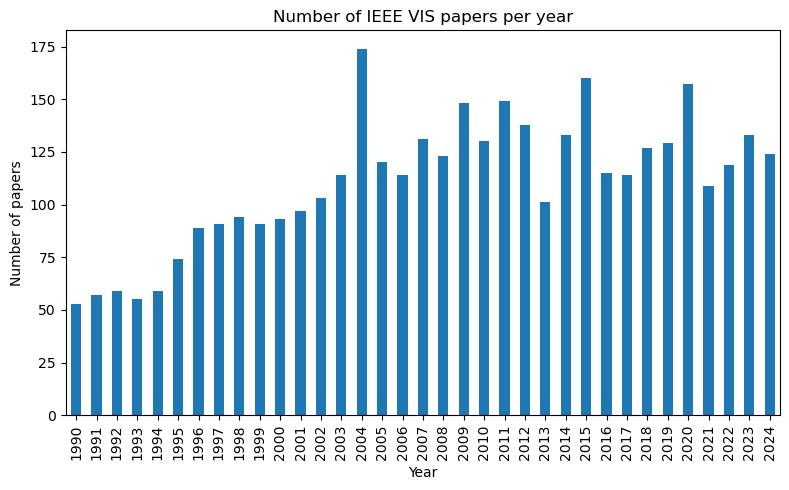

In [8]:

# Plot: number of papers per year
plt.figure()
papers_per_year.plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.title("Number of IEEE VIS papers per year")
plt.tight_layout()
plt.show()


In [9]:

# Helper: count authors for each paper using the deduplicated author column if available
author_col = "AuthorNames-Deduped" if "AuthorNames-Deduped" in df.columns else "AuthorNames"

def count_authors(author_string):
    if pd.isna(author_string):
        return 0
    # Split on semicolon or comma as a fallback
    parts = [a.strip() for a in str(author_string).replace(",", ";").split(";")]
    parts = [p for p in parts if p]
    return len(parts)

df["NumAuthors"] = df[author_col].apply(count_authors)
df["NumAuthors"].describe()


count    3877.000000
mean        3.946866
std         2.051646
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        21.000000
Name: NumAuthors, dtype: float64

In [10]:

# Average number of authors per paper per year
avg_authors_per_year = df.groupby("Year")["NumAuthors"].mean()
print(avg_authors_per_year)


Year
1990    2.264151
1991    2.824561
1992    2.677966
1993    2.345455
1994    2.864407
1995    2.635135
1996    3.303371
1997    2.879121
1998    2.787234
1999    3.076923
2000    3.204301
2001    3.288660
2002    2.941748
2003    3.201754
2004    3.344828
2005    3.658333
2006    3.403509
2007    3.862595
2008    3.756098
2009    3.851351
2010    3.769231
2011    4.053691
2012    4.224638
2013    4.128713
2014    4.609023
2015    4.462500
2016    4.686957
2017    4.728070
2018    4.629921
2019    5.255814
2020    5.050955
2021    5.045872
2022    5.378151
2023    5.330827
2024    4.701613
Name: NumAuthors, dtype: float64


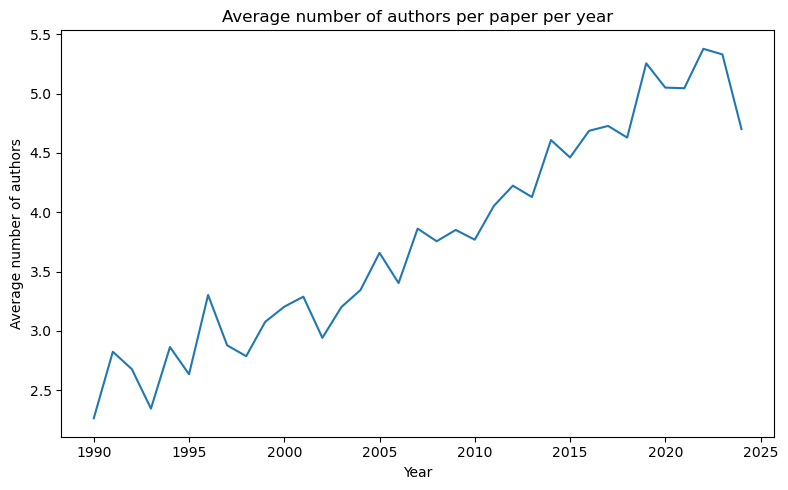

In [11]:

# Plot: average number of authors per year
plt.figure()
avg_authors_per_year.plot()
plt.xlabel("Year")
plt.ylabel("Average number of authors")
plt.title("Average number of authors per paper per year")
plt.tight_layout()
plt.show()


In [12]:

# Papers per year by Conference
if "Conference" in df.columns:
    papers_per_year_conf = df.pivot_table(index="Year", columns="Conference", values="Title", aggfunc="count").fillna(0)
    papers_per_year_conf.head()
else:
    papers_per_year_conf = None
    print("No 'Conference' column found.")


<Figure size 800x500 with 0 Axes>

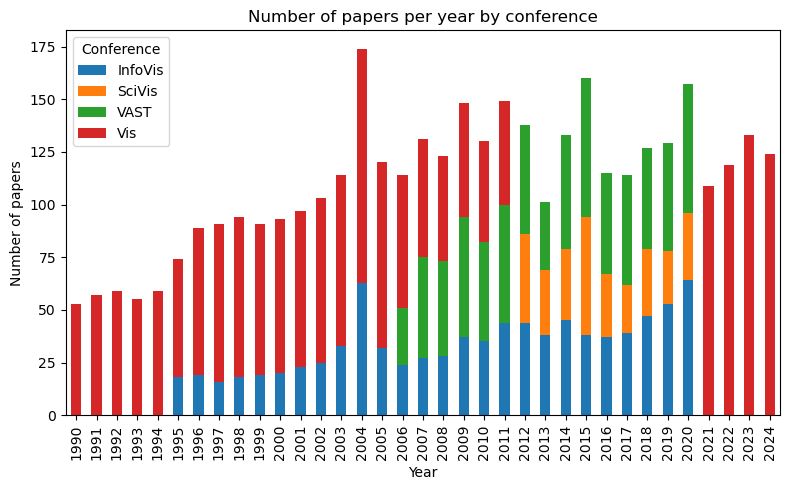

In [13]:

# Plot: stacked papers per year by Conference (if available)
if papers_per_year_conf is not None:
    plt.figure()
    papers_per_year_conf.plot(kind="bar", stacked=True)
    plt.xlabel("Year")
    plt.ylabel("Number of papers")
    plt.title("Number of papers per year by conference")
    plt.tight_layout()
    plt.show()


In [14]:

# Papers per year by PaperType (if available)
if "PaperType" in df.columns:
    papers_per_year_type = df.pivot_table(index="Year", columns="PaperType", values="Title", aggfunc="count").fillna(0)
    papers_per_year_type.head()
else:
    papers_per_year_type = None
    print("No 'PaperType' column found.")


<Figure size 800x500 with 0 Axes>

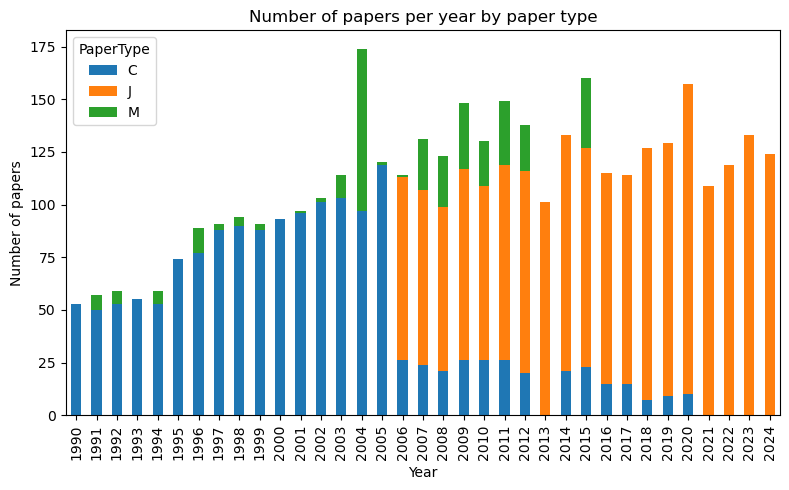

In [15]:

# Plot: papers per year by PaperType
if papers_per_year_type is not None:
    plt.figure()
    papers_per_year_type.plot(kind="bar", stacked=True)
    plt.xlabel("Year")
    plt.ylabel("Number of papers")
    plt.title("Number of papers per year by paper type")
    plt.tight_layout()
    plt.show()



### Temporal analysis commentary

- The bar chart of papers per year illustrates how the VIS community has grown over time, with noticeable changes in volume corresponding to major reorganizations of the conference structure and the addition of tracks.
- The average number of authors per paper provides insight into collaboration practices: an increasing trend often reflects larger teams, interdisciplinary work, or both.
- The stacked breakdown by conference and paper type shows how different sub-communities and submission categories contribute to the total volume.



## 5. Author analysis

We now explore:
- total and unique authors,
- distribution of authors per year,
- top authors by number of papers,
- basic co-authorship network structure.


In [16]:

# Extract normalized list of authors from the deduplicated column
author_col = "AuthorNames-Deduped" if "AuthorNames-Deduped" in df.columns else "AuthorNames"

def split_authors(author_string):
    if pd.isna(author_string):
        return []
    parts = [a.strip() for a in str(author_string).replace(",", ";").split(";")]
    return [p for p in parts if p]

df["AuthorList"] = df[author_col].apply(split_authors)

all_authors = [a for sub in df["AuthorList"] for a in sub]
len(all_authors), len(set(all_authors))


(15302, 7210)

In [17]:

# Top authors by number of papers
author_counts = Counter(all_authors)
top_authors = pd.DataFrame(author_counts.most_common(30), columns=["Author", "PaperCount"])
top_authors


,Author,PaperCount
0,Kwan-Liu Ma,78
1,Huamin Qu,75
2,Hanspeter Pfister,68
3,M. Eduard Gröller,67
4,Daniel A. Keim,60
5,Arie E. Kaufman,59
6,Yingcai Wu,55
7,Thomas Ertl,54
8,Cláudio T. Silva,49
9,Daniel Weiskopf,48


In [18]:

# Distribution of number of papers per author
author_papers = pd.Series(author_counts)
author_papers.describe(), author_papers.value_counts().head(10)


(count    7210.000000
 mean        2.122330
 std         3.878729
 min         1.000000
 25%         1.000000
 50%         1.000000
 75%         2.000000
 max        78.000000
 dtype: float64,
 1     5040
 2     1043
 3      384
 4      180
 5      122
 6       90
 7       63
 8       53
 9       31
 10      26
 Name: count, dtype: int64)

In [19]:

# Authors per year: number of unique authors active in each year
authors_per_year = df.explode("AuthorList").groupby("Year")["AuthorList"].nunique()
authors_per_year


Year
1990    119
1991    157
1992    150
1993    122
1994    161
1995    180
1996    255
1997    230
1998    244
1999    249
2000    267
2001    281
2002    275
2003    317
2004    501
2005    392
2006    342
2007    404
2008    407
2009    470
2010    416
2011    509
2012    490
2013    349
2014    502
2015    597
2016    443
2017    453
2018    496
2019    547
2020    648
2021    456
2022    530
2023    587
2024    507
Name: AuthorList, dtype: int64

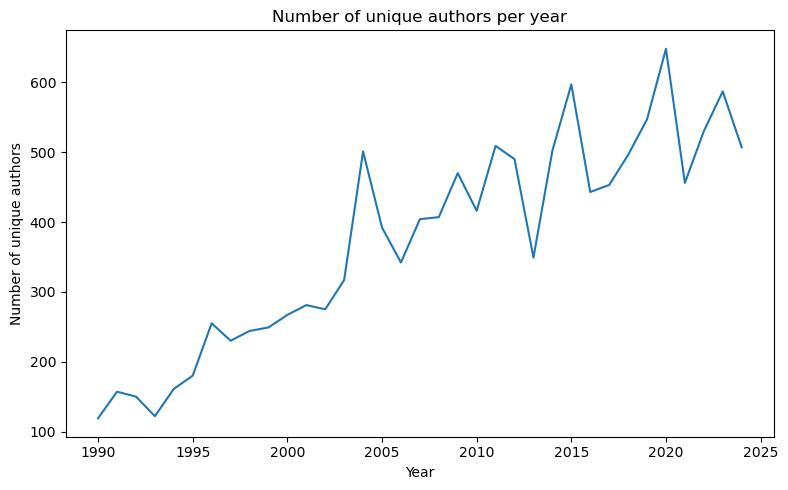

In [20]:

# Plot: unique authors per year
plt.figure()
authors_per_year.plot()
plt.xlabel("Year")
plt.ylabel("Number of unique authors")
plt.title("Number of unique authors per year")
plt.tight_layout()
plt.show()


In [21]:

# Build a co-authorship network (undirected)
G_authors = nx.Graph()

for authors in df["AuthorList"]:
    if not authors:
        continue
    # Add all authors
    for a in authors:
        if not G_authors.has_node(a):
            G_authors.add_node(a)
    # Add edges for all pairs in the paper
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            a1, a2 = authors[i], authors[j]
            if G_authors.has_edge(a1, a2):
                G_authors[a1][a2]["weight"] += 1
            else:
                G_authors.add_edge(a1, a2, weight=1)

len(G_authors.nodes()), len(G_authors.edges())


(7210, 24944)

In [22]:

# Basic co-authorship network statistics
degrees = dict(G_authors.degree())
degree_series = pd.Series(degrees)
print("Degree stats:")
print(degree_series.describe())

# Top authors by degree (most collaborators)
top_by_degree = degree_series.sort_values(ascending=False).head(20)
top_by_degree


Degree stats:
count    7210.000000
mean        6.919279
std         9.936928
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max       216.000000
dtype: float64


Huamin Qu            216
Hanspeter Pfister    197
Wei Chen 0001        193
Yingcai Wu           150
M. Eduard Gröller    144
Daniel A. Keim       138
Cláudio T. Silva     137
Kwan-Liu Ma          124
David S. Ebert       123
Thomas Ertl          114
Daniel Weiskopf      109
Tobias Schreck       108
Valerio Pascucci     102
Niklas Elmqvist       97
Shixia Liu            96
Arie E. Kaufman       94
Benjamin Bach         89
Xiaoru Yuan           87
Remco Chang           86
Bernd Hamann          86
dtype: int64


> **Note:** For visualization of large co-authorship graphs, tools such as Gephi, Cytoscape, or interactive Python libraries (e.g., PyVis, Plotly) are recommended. In this notebook we focus on structural statistics (degree, number of nodes/edges), but the graph object `G_authors` is ready to be exported (e.g., to GEXF) for external visualization.



## 6. Field and topic analysis

We analyze the **AuthorKeywords** to understand the main application domains and themes.  
We also perform a simple **topic modeling** on the abstracts to uncover latent topics.


In [23]:

# Clean and split keywords
def split_keywords(kw_string):
    if pd.isna(kw_string):
        return []
    # Common separators: semicolon, comma
    parts = [k.strip().lower() for k in str(kw_string).replace(",", ";").split(";")]
    return [p for p in parts if p]

df["KeywordList"] = df["AuthorKeywords"].apply(split_keywords) if "AuthorKeywords" in df.columns else [[]]

all_keywords = [k for sub in df["KeywordList"] for k in sub]
len(all_keywords), len(set(all_keywords))


(13351, 6593)

In [24]:

# Top 50 keywords
keyword_counts = Counter(all_keywords)
top_keywords = pd.DataFrame(keyword_counts.most_common(50), columns=["Keyword", "Count"])
top_keywords


,Keyword,Count
0,visual analytics,275
1,visualization,233
2,information visualization,205
3,volume rendering,155
4,flow visualization,91
5,interaction,71
6,scientific visualization,68
7,volume visualization,61
8,evaluation,60
9,uncertainty visualization,53


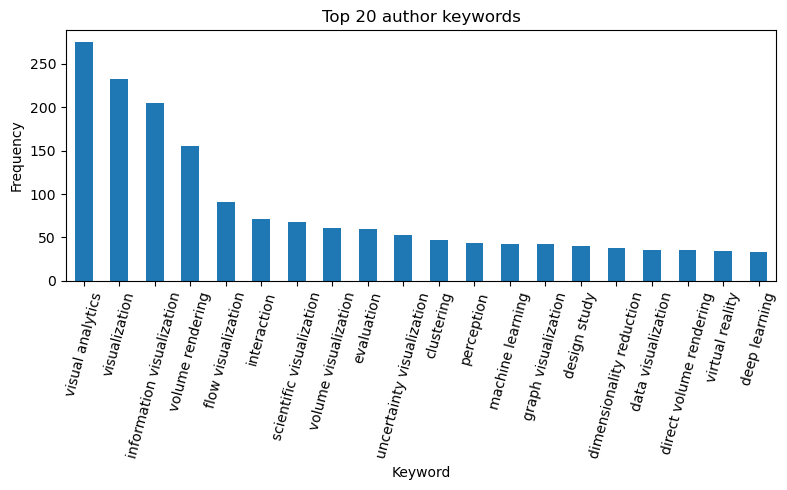

In [25]:

# Plot: top 20 keywords
top20 = top_keywords.head(20).set_index("Keyword")
plt.figure()
top20["Count"].plot(kind="bar")
plt.xlabel("Keyword")
plt.ylabel("Frequency")
plt.title("Top 20 author keywords")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()



### Mapping keywords to high-level domains

We create a simple rule-based mapping from keywords to high-level domains such as:
- **Core Visualization**
- **Machine Learning / AI**
- **Biology / Medicine**
- **Geospatial / Urban / Architecture**
- **Social / Humanities**
- **Business / Finance / Industry**
- **Other**


In [26]:

# Define domain mapping rules (simple keyword-based)
domain_rules = {
    "Machine Learning / AI": [
        "machine learning", "deep learning", "neural network", "neural networks", "classification", "prediction", "clustering", "ai", "artificial intelligence"
    ],
    "Biology / Medicine": [
        "bio", "biology", "bioinformatics", "genomics", "molecular", "medical", "medicine", "clinical", "patient", "health", "healthcare"
    ],
    "Geospatial / Urban / Architecture": [
        "geo", "geospatial", "gis", "map", "maps", "urban", "city", "cities", "cartography", "spatial"
    ],
    "Social / Humanities": [
        "social", "sociology", "humanities", "history", "politics", "communication", "opinion", "sentiment"
    ],
    "Business / Finance / Industry": [
        "finance", "financial", "business", "market", "marketing", "industry", "logistics", "supply chain"
    ],
    "Core Visualization": [
        "visualization", "visualisation", "infoVis".lower(), "visual analytics", "interaction", "user study", "evaluation", "graphs", "networks", "volume rendering"
    ]
}

def classify_keyword_to_domains(keyword):
    domains = set()
    for domain, patterns in domain_rules.items():
        for p in patterns:
            if p in keyword:
                domains.add(domain)
    if not domains:
        domains.add("Other")
    return list(domains)

# Assign domains to each paper based on its keywords
def infer_domains(keyword_list):
    domains = set()
    for kw in keyword_list:
        for d in classify_keyword_to_domains(kw):
            domains.add(d)
    return list(domains)

df["Domains"] = df["KeywordList"].apply(infer_domains)
df["Domains"].head()


0                          [Core Visualization, Other]
1                          [Core Visualization, Other]
2     [Core Visualization, Other, Social / Humanities]
3    [Core Visualization, Geospatial / Urban / Arch...
4                          [Core Visualization, Other]
Name: Domains, dtype: object

In [27]:

# Count domain frequencies
all_domains = [d for sub in df["Domains"] for d in sub]
domain_counts = Counter(all_domains)
domain_counts


Counter({'Other': 2805,
         'Core Visualization': 2069,
         'Machine Learning / AI': 519,
         'Geospatial / Urban / Architecture': 335,
         'Biology / Medicine': 172,
         'Social / Humanities': 88,
         'Business / Finance / Industry': 15})

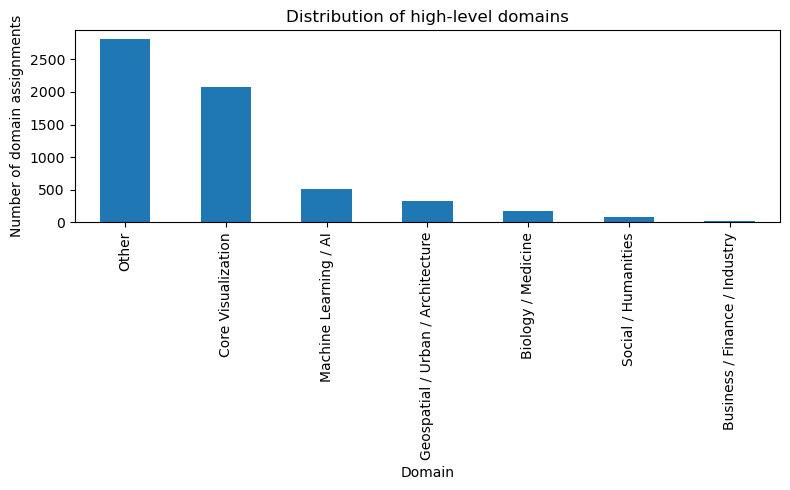

In [28]:

# Plot domain distribution
domain_series = pd.Series(domain_counts).sort_values(ascending=False)
plt.figure()
domain_series.plot(kind="bar")
plt.xlabel("Domain")
plt.ylabel("Number of domain assignments")
plt.title("Distribution of high-level domains")
plt.tight_layout()
plt.show()


In [29]:

# Domains per year
domain_year_list = []

for _, row in df.iterrows():
    year = row["Year"]
    for d in row["Domains"]:
        domain_year_list.append((year, d))

domain_year_df = pd.DataFrame(domain_year_list, columns=["Year", "Domain"])
domains_per_year = domain_year_df.pivot_table(index="Year", columns="Domain", values="Domain", aggfunc="count").fillna(0)
domains_per_year.head()


Domain
Year
1991
1992
1993
1994
1995


In [31]:

# Plot: domains over time (stacked)
plt.figure()
domains_per_year.plot(kind="bar", stacked=True)
plt.xlabel("Year")
plt.ylabel("Number of domain assignments")
plt.title("Domains over time (stacked)")
plt.tight_layout()
plt.show()


TypeError: no numeric data to plot

<Figure size 800x500 with 0 Axes>


### Simple topic modeling on abstracts (LDA)

We perform a basic Latent Dirichlet Allocation (LDA) topic modeling on the abstracts in order to identify latent topics.
This is **exploratory** and should be interpreted qualitatively.


In [ ]:

# Prepare text corpus from abstracts
abstracts = df["Abstract"].dropna().astype(str).tolist()

# Use a simple bag-of-words representation
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=10,
    stop_words="english"
)
X = vectorizer.fit_transform(abstracts)

# Fit LDA
n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

feature_names = vectorizer.get_feature_names_out()

def print_top_words(model, feature_names, n_top_words=15):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print_top_words(lda, feature_names)



> **Interpretation:**  
> Each topic is represented by a set of high-probability words. By reading these word lists, we can qualitatively label topics (e.g., *graph visualization*, *volume rendering*, *evaluation/user studies*, *machine learning & models*, etc.).  
> This provides an alternative perspective to the rule-based domain mapping from author keywords.



## 7. Network analysis

We now build some networks:

1. **Author–author** (co-authorship) — already constructed as `G_authors`.
2. **Author–domain** bipartite graph.
3. **Institution/city–domain** bipartite graph (simple heuristic parsing).

These graphs can be exported for visualization in external tools.


In [32]:

# Author–Domain bipartite graph
B_author_domain = nx.Graph()

for _, row in df.iterrows():
    authors = row["AuthorList"]
    domains = row["Domains"]
    for a in authors:
        if not B_author_domain.has_node(a):
            B_author_domain.add_node(a, bipartite="author")
    for d in domains:
        if not B_author_domain.has_node(d):
            B_author_domain.add_node(d, bipartite="domain")
    for a in authors:
        for d in domains:
            if B_author_domain.has_edge(a, d):
                B_author_domain[a][d]["weight"] += 1
            else:
                B_author_domain.add_edge(a, d, weight=1)

len(B_author_domain.nodes()), len(B_author_domain.edges())


(7217, 13541)

In [33]:

# Basic stats: which domains have the most unique authors
domain_nodes = [n for n, d in B_author_domain.nodes(data=True) if d.get("bipartite") == "domain"]
domain_author_counts = {}

for domain in domain_nodes:
    neighbors = list(B_author_domain.neighbors(domain))
    domain_author_counts[domain] = len(neighbors)

pd.Series(domain_author_counts).sort_values(ascending=False)


Other                                5569
Core Visualization                   4466
Machine Learning / AI                1498
Geospatial / Urban / Architecture     989
Biology / Medicine                    653
Social / Humanities                   297
Business / Finance / Industry          69
dtype: int64

In [34]:

# Institution/City extraction (very heuristic)
def parse_affiliations(aff_str):
    if pd.isna(aff_str):
        return []
    parts = [p.strip() for p in str(aff_str).split(";")]
    return [p for p in parts if p]

df["AffiliationList"] = df["AuthorAffiliation"].apply(parse_affiliations) if "AuthorAffiliation" in df.columns else [[]]

# Build institution-domain bipartite graph (very rough)
B_inst_domain = nx.Graph()

for _, row in df.iterrows():
    affs = row["AffiliationList"]
    domains = row["Domains"]
    for aff in affs:
        if not B_inst_domain.has_node(aff):
            B_inst_domain.add_node(aff, bipartite="affiliation")
    for d in domains:
        if not B_inst_domain.has_node(d):
            B_inst_domain.add_node(d, bipartite="domain")
    for aff in affs:
        for d in domains:
            if B_inst_domain.has_edge(aff, d):
                B_inst_domain[aff][d]["weight"] += 1
            else:
                B_inst_domain.add_edge(aff, d, weight=1)

len(B_inst_domain.nodes()), len(B_inst_domain.edges())


(4900, 8766)

In [35]:

# Which affiliations appear most often?
all_affs = [a for sub in df["AffiliationList"] for a in sub]
aff_counts = pd.Series(Counter(all_affs)).sort_values(ascending=False)
aff_counts.head(30)


University of Konstanz, Germany                                                                    156
Hong Kong University of Science and Technology                                                     118
State Key Lab of CAD&CG, Zhejiang University, China                                                 97
Pacific Northwest National Laboratory, USA                                                          71
Northwestern University, USA                                                                        64
Scientific Computing and Imaging Institute, University of Utah, USA                                 63
Microsoft Research                                                                                  61
University of California, Davis, USA                                                                55
University of Utah, USA                                                                             54
New York University                                                      


> **Note:** The parsing of affiliations is intentionally simple and can be improved by:
> - Matching known university names,
> - Extracting cities and countries with regular expressions or external gazetteers,
> - Normalizing institution names (e.g., handling variants and abbreviations).



## 8. Visual summaries

Finally, we build a simple **year × domain** heatmap-like structure using a pivot table, which can be exported or visualized in other tools.


In [36]:

# Year × Domain table
year_domain_table = domains_per_year.copy()
year_domain_table.head()


Domain
Year
1991
1992
1993
1994
1995


/var/folders/j6/2938yrws23qf7snjhdg6gjdw0000gn/T/ipykernel_49881/2204872533.py:3: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(year_domain_table.T, aspect="auto", interpolation="nearest")


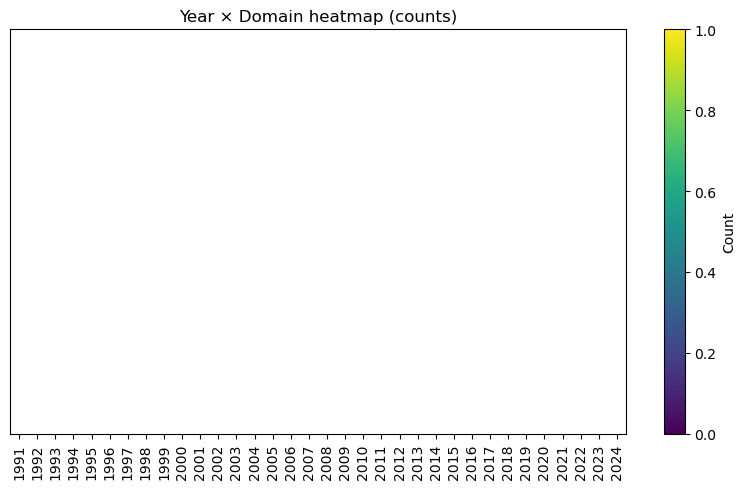

In [37]:

# Simple imshow-style heatmap using matplotlib (for compact view)
plt.figure()
plt.imshow(year_domain_table.T, aspect="auto", interpolation="nearest")
plt.colorbar(label="Count")
plt.yticks(range(len(year_domain_table.columns)), year_domain_table.columns)
plt.xticks(range(len(year_domain_table.index)), year_domain_table.index, rotation=90)
plt.title("Year × Domain heatmap (counts)")
plt.tight_layout()
plt.show()



## 9. Conclusions and next steps

This notebook provided a **comprehensive EDA** of the IEEE VIS 1990–2024 dataset, including:

- Basic structure and column-by-column profiling.
- Temporal evolution of the field (papers, authors, conferences, and paper types).
- Author-level analysis and co-authorship structures.
- Domain and topic analysis via keywords and abstract-based topic modeling.
- Construction of multiple networks (author–author, author–domain, affiliation–domain).
- Visual summaries (time series plots and a year × domain heatmap).

Possible next steps:

- Refine the domain classification (manual curation, more sophisticated NLP).
- Export networks (e.g., GEXF, GraphML) and visualize them in Gephi.
- Focus on specific regions (e.g., Italy, particular cities or institutions) to study local sub-communities.
- Implement interactive dashboards (e.g., with Plotly Dash, Panel, or Streamlit) for exploratory exploration.
